In [2]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

/tmp/ipykernel_9160/47578708.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
import torch
print("Using torch", torch.__version__)

Using torch 1.13.0


In [4]:
torch.manual_seed(42) # Setting the seed

Suppose we have the function:

$$y = \frac{1}{|x|}\sum_i \left[(x_i + 2)^2 + 3\right]$$

with $x$ a 3-element vector. 

Computing the gradient of $y$ with respect to $x$ is straightforward:

In [8]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)
print(x)
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()

y.backward()

tensor([0., 1., 2.], requires_grad=True)


In [7]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

Indeed if we were to manually calculate the gradient, we would get:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$\frac{\partial a_i}{\partial x_i} = 1,\hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i\hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1\hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}$$

So the gradient is:

$$\frac{\partial y}{\partial x} = \frac{2}{3}\left[a_1, a_2, a_3\right]$$

Which is indeed correct

In [9]:
# gpu support checked via
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [13]:
# torch makes sending tensors to the GPU relatively easy too
x1 = torch.arange(3, dtype=torch.float32)
x1 = x1.to(device)

# or
x2 = torch.arange(3, dtype=torch.float32, device=device)
print(x1)
print(x2)

tensor([0., 1., 2.], device='cuda:0')
tensor([0., 1., 2.], device='cuda:0')


In [18]:
# GPU operations can have significant performace benefits

x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

print(f"Speedup: {(end_time - start_time) / (0.001 * start.elapsed_time(end)):.2f}x")
# on beefier GPU, speedup can be 50-100x

CPU time: 0.56866s
GPU time: 0.09019s
Speedup: 6.30x


In [19]:
# seeding random numbers works a bit differently on GPU

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Note that due to different GPU architectures, running the same code on different GPUs does not guarantee the same random numbers.

## Example

### Continuous XOR

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [22]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [23]:
# The parameters of a module can be obtained by using its parameters() functions, or named_parameters() to get a name to each parameter object. For our small neural network, we have the following parameters:

for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [24]:
# the data
import torch.utils.data as data

In [25]:
class XORDataset(data.Dataset):
    def __init__(self, size, std_dev=0.1):
        super().__init__()
        self.size = size
        self.std_dev = std_dev
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).float()

        # Add noise
        data += torch.randn_like(data) * self.std_dev

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return self.data[index], self.label[index]
        

In [26]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([1.0484, 0.9858]), tensor(0.))


In [27]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

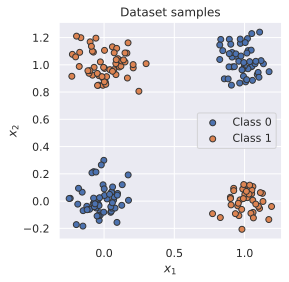

In [28]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [ ]:
# now we will create a data loader to load the data in batches